# CS440/ECE448 Spring 2023
# MP11: Reinforcement Learning

The first thing you need to do is to download this file: <a href="mp11.zip">mp11.zip</a>.  If you want, you can also download <a href="mp11_extra.zip">mp11_extra.zip</a>, the extra credit assignment.  `mp11.zip` has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp11_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `pong.py`: This is a program that plays Pong.  If called interactively, it will call the module `pong_display.py` to create a display, so that you can play.  If told to use a Q-learner, it will call your `submitted.py` to do Q-learning.
* `grade.py`: Once your homework seems to be working, you can test it by typing `python grade.py`, which will run the tests in `tests/tests_visible.py`.
* `tests/test_visible.py`: This file contains about half of the <a href="https://docs.python.org/3/library/unittest.html">unit tests</a> that Gradescope will run in order to grade your homework.  If you can get a perfect score on these tests, then you should also get a perfect score on the additional hidden tests that Gradescope uses.
* `requirements.txt`: This tells you which python packages you need to have installed, in order to run `grade.py`.  You can install all of those packages by typing `pip install -r requirements.txt` or `pip3 install -r requirements.txt`.

This file (`mp11_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Table of Contents

1. <a href="#section1">Playing Pong</a>
1. <a href="#section2">Creating a Q-Learner Object</a>
1. <a href="#section3">Epsilon-First Exploration</a>
1. <a href="#section4">Q-Learning</a>
1. <a href="#section5">Saving and Loading Your Q and N Tables</a>
1. <a href="#section6">Exploitation</a>
1. <a href="#section7">Acting</a>
1. <a href="#section8">Training</a>
1. <a href="#section9">Extra Credit</a>
1. <a href="#grade">Grade Your Homework</a>

<a id='section1'></a>

## Playing Pong

Pong was the <a href="https://en.wikipedia.org/wiki/Pong">first video game produced by Atari.</a>  It is a simple game, based on table tennis.  Here is a two-person version of the game: https://commons.wikimedia.org/wiki/File:Pong_Game_Test2.gif

We will be playing a one-person version of the game:

* When the ball hits the top, bottom, or left wall of the playing field, it bounces.
* The right end of the playing field is open, except for the paddle.  If the ball hits the paddle, it bounces, and the player's score increments by one.  If the ball hits the open space, the game is over; the score resets to zero, and a new game begins.

The game is pretty simple, but in order to get a better feeling for it, you may want to try playing it yourself.  Use the up arrow to move the paddle upward, and the down arrow to move the paddle downward.  See how high you can make your score:


In [1]:
!python pong.py

pygame 2.3.0 (SDL 2.24.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Completed 0 games, 3 rewards, 1012 frames, score 2, max score 2
Completed 1 games, 4 rewards, 1220 frames, score 0, max score 2


Once you figure out how to use the arrow keys to control your paddle, we hope you will find that the game is not too hard for a human to play.  However, for a computer, it's difficult to know: where should the paddle be moved at each time step?  In order to see how difficult it is for a computer to play, let's ask the "random" player to play the game.

**WARNING:** The following line will open a pygame window.  The pygame window will be hidden by this window -- in order to see it, you will need to minimize this window.  The pygame window will consume a lot of CPU time just waiting for the processor, so in order to kill it, you will need to come back to this window, click on the block below, then click the Jupyter "stop" button (the square button at the top of this window) in order to stop processing.

In [2]:
!python pong.py --player random

pygame 2.3.0 (SDL 2.24.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Completed 0 games, 1 rewards, 182 frames, score 0, max score 0
Completed 1 games, 2 rewards, 390 frames, score 0, max score 0
Completed 2 games, 3 rewards, 571 frames, score 0, max score 0
Completed 3 games, 4 rewards, 752 frames, score 0, max score 0
^C
Traceback (most recent call last):
  File "/Users/jhasegaw/Dropbox/mark/teaching/ece448/ece448labs/spring23/mp11/src/pong.py", line 270, in <module>
    application.run()
  File "/Users/jhasegaw/Dropbox/mark/teaching/ece448/ece448labs/spring23/mp11/src/pong.py", line 170, in run
    self.display.update_display()
  File "/Users/jhasegaw/Dropbox/mark/teaching/ece448/ece448labs/spring23/mp11/src/pong_display.py", line 65, in update_display
    self.fps.tick(60)
KeyboardInterrupt


<a id='section2'></a>

## Creating a Q-Learner Object

The first thing you will do is to create a `q_learner` object that can store your learned Q table and your N table (table of exploration counts).  

Like any other object-oriented language, python permits you to create new object classes in order to store data that will be needed from time to time.  If you are not already very, very familiar with python classes, you might want to study the python class tutorial: https://docs.python.org/3/tutorial/classes.html

Like any other object in python, a `q_learner` object is created by calling its name as a function, e.g., `my_q_learner=submitted.q_learner()`.  Doing so calls the function `submitted.q_learner.__init__()`.  Let's look at the docstring to see what it should do.

In [3]:
import submitted, importlib
importlib.reload(submitted)
help(submitted.q_learner.__init__)

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst, state_cardinality)
    Create a new q_learner object.
    Your q_learner object should store the provided values of alpha,
    epsilon, gamma, and nfirst.
    It should also create a Q table and an N table.
    Q[...state..., ...action...] = expected utility of state/action pair.
    N[...state..., ...action...] = # times state/action has been explored.
    Both are initialized to all zeros.
    Up to you: how will you encode the state and action in order to
    define these two lookup tables?  The state will be a list of 5 integers,
    such that 0 <= state[i] < state_cardinality[i] for 0 <= i < 5.
    The action will be either -1, 0, or 1.
    It is up to you to decide how to convert an input state and action
    into indices that you can use to access your stored Q and N tables.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of takin

Write your `__init__` function to meet the requirements specified in the docstring.  Once you have completed it, the following code should run without errors:

In [4]:
importlib.reload(submitted)

q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])

print(q_learner)


<a id='section3'></a>

## Epsilon-First Exploration

In order to manage the exploration/exploitation tradeoff, we will be using both "epsilon-first" and "epsilon-greedy" (https://en.wikipedia.org/wiki/Multi-armed_bandit#Semi-uniform_strategies).  

The epsilon-first strategy explores every state/action pair at least `nfirst` times before it ever starts to exploit any strategy.  Your `q_learner` should have a table to keep track of how many times it has explored a state/action pair prior to the start of any exploitation.  The method for storing that table is up to you; in order to have some standardized API, therefore, you need to write a method called `report_exploration_counts` that returns a list of the three exploration counts for a given state. 

In [5]:
importlib.reload(submitted)
help(submitted.q_learner.report_exploration_counts)

Help on function report_exploration_counts in module submitted:

report_exploration_counts(self, state)
    Check to see how many times each action has been explored in this state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    explored_count (array of 3 ints): 
      number of times that each action has been explored from this state.
      The mapping from actions to integers is up to you, but there must be three of them.



Write `report_exploration_counts` so that it returns a list or array for any given state.  Test your code with the following:

In [6]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('This is how many times state [0,0,0,0,0] has been explored so far:')
print(q_learner.report_exploration_counts([0,0,0,0,0]))
print('This is how many times state [9,9,1,1,9] has been explored so far:')
print(q_learner.report_exploration_counts([9,9,1,1,9]))

This is how many times state [0,0,0,0,0] has been explored so far:
[0. 0. 0.]
This is how many times state [9,9,1,1,9] has been explored so far:
[0. 0. 0.]


When your learner first starts learning, it will call the function `choose_unexplored_action` to choose an unexplored action.  This function should choose a function uniformly at random from the set of unexplored actions in a given state, if there are any:

In [7]:
importlib.reload(submitted)
help(submitted.q_learner.choose_unexplored_action)

Help on function choose_unexplored_action in module submitted:

choose_unexplored_action(self, state)
    Choose an action that has been explored less than nfirst times.
    If many actions are underexplored, you should choose uniformly
    from among those actions; don't just choose the first one all
    the time.
    
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar): either -1, or 0, or 1, or None
      If all actions have been explored at least n_explore times, return None.
      Otherwise, choose one uniformly at random from those w/count less than n_explore.
      When you choose an action, you should increment its count in your counter table.



If this has been written correctly, the following block should generate a random sequence of actions.  If the next block produces the same action 5 times in a row, that is the wrong result, and the result would be that your code does not pass the autograder.

In [8]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: -1
Next action: 0
Next action: 0
Next action: 1
Next action: -1


After all three actions have been explored `nfirst` times, the function `choose_unexplored_action` should return `None`, as shown here:

In [9]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,1,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: -1
Next action: 1
Next action: 0
Next action: None


<a id='section4'></a>

## Q-Learning

The reinforcement learning we are implementing is called Q-learning (https://en.wikipedia.org/wiki/Q-learning).  

Q-learning keeps a table $Q[s,a]$ that specifies the expected utility of action $a$ in state $s$.  The organization of this table is up to you.  In order to have a standard API, the first thing you should implement is a function `report_q` with the following docstring:

In [10]:
importlib.reload(submitted)
help(submitted.q_learner.report_q)

Help on function report_q in module submitted:

report_q(self, state)
    Report the current Q values for the given state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q (array of 3 floats): 
      reward plus expected future utility of each of the three actions. 
      The mapping from actions to integers is up to you, but there must be three of them.



When your `q_learner` is first initialized, the value of $Q[state,action]$ should be zero for all state/action pairs, thus the `report_q` function should return lists of zeros:

In [11]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Q[0,0,0,0,0] is now:',q_learner.report_q([0,0,0,0,0]))
print('Q[9,9,1,1,9] is now:',q_learner.report_q([9,9,1,1,9]))

Q[0,0,0,0,0] is now: [0. 0. 0.]
Q[9,9,1,1,9] is now: [0. 0. 0.]


There are actually many different Q-learning algorithms available, but when people refer to Q-learning with no modifier, they usually mean the time-difference (TD) algorithm.  For example, this is the algorithm that's described on the wikipedia page (https://en.wikipedia.org/wiki/Q-learning).  This is the algorithm you will implement for this MP.

In supervised machine learning, the learner tries to imitate a reference label.  In reinforcement learning, there is no reference label.  Q-learning replaces the reference label with a "local Q" value, which is the utility that was obtained by performing action $a$ in state $s$ one time.  It is usually calculated like this:

$$Q_{local}(s_t,a_t) = r_t + \gamma\max_{a_{t+1}}Q(s_{t+1},a_{t+1})$$

where $r_t$ is the reward that was achieved by performing action $a_t$ in state $s_t$, $s_{t+1}$ is the state into which the game transitioned, and $a_{t+1}$ is one of the actions that could be performed in that state.  $Q_{local}$ is computed by your `q_local` function, which has this docstring:  

In [12]:
importlib.reload(submitted)
help(submitted.q_learner.q_local)

Help on function q_local in module submitted:

q_local(self, reward, newstate)
    The update to Q estimated from a single step of game play:
    reward plus gamma times the max of Q[newstate, ...].
    
    @param:
    reward (scalar float): the reward achieved from the current step of game play.
    newstate (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q_local (scalar float): the local value of Q



Initially, `q_local` should just return the given reward, because initially, all Q values are 0:

In [26]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,10,10])
print('Q_local(6.25,[9,9,1,1,9]) is currently:',q_learner.q_local(6.25,[9,9,1,1,9]))

Q_local(6.25,[9,9,1,1,9]) is currently: 6.25


Now you can use `q_learner.q_local` as the target for `q_learner.learn`.  The basic algorithm is

$$Q(s,a) = Q(s,a) + \alpha (Q_{local}(s,a)-Q(s,a))$$

Here is the docstring:

In [27]:
importlib.reload(submitted)
help(submitted.q_learner.learn)

Help on function learn in module submitted:

learn(self, state, action, reward, newstate)
    Update the internal Q-table on the basis of an observed
    state, action, reward, newstate sequence.
    
    @params:
    state: a list of 5 numbers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle.
    action: an integer, one of -1, 0, or +1
    reward: a reward; positive for hitting the ball, negative for losing a game
    newstate: a list of 5 numbers, in the same format as state
    
    @return:
    None



The following block checks a sequence of Q updates:

1. First, $Q([9,9,1,1,9],-1)$ is updated.  Since all Q values start at zero, it will be updated to just have a value equal to $\alpha$ (0.05) times the given reward (6.25) for a total value of 0.3125.
1. When we print out $Q([9,9,1,1,9],:)$, we see that one of the elements has been updated.
1. Next, update $Q([9,9,1,1,8],1)$ with a given reward, and with $[9,9,1,1,9]$ as the given next state.  Since $Q([9,9,1,1,9],-1)$ is larger than zero, the next-state Q-value should be multiplied by $\gamma$ (0.99) and added to the reward (3.1), then multiplied by $\alpha$, giving a total value of 0.17046875.
1. The resulting Q-value is reported.

In [28]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q[9,9,1,1,9] is now',q_learner.report_q([9,9,1,1,9]))
q_learner.learn([9,9,1,1,8],1,3.1,[9,9,1,1,9])
print('Q[9,9,1,1,8] is now',q_learner.report_q([9,9,1,1,8]))

Q[9,9,1,1,9] is now [0.     0.     0.3125]
Q[9,9,1,1,8] is now [0.         0.17046875 0.        ]


<a id='section5'></a>

## Saving and Loading your Q and N Tables

After you've spent a long time training your `q_learner`, you will want to save your Q and N tables so that you can reload them later.  The format of Q and N is up to you, therefore it's also up to you to write the `save` and `load` functions.  Here are the docstrings:

In [29]:
importlib.reload(submitted)
help(submitted.q_learner.save)

Help on function save in module submitted:

save(self, filename)
    Save your Q and N tables to a file.
    This can save in any format you like, as long as your "load" 
    function uses the same file format.  We recommend numpy.savez,
    but you can use something else if you prefer.
    
    @params:
    filename (str) - filename to which it should be saved
    @return:
    None



In [30]:
importlib.reload(submitted)
help(submitted.q_learner.load)

Help on function load in module submitted:

load(self, filename)
    Load the Q and N tables from a file.
    This should load from whatever file format your save function
    used.  We recommend numpy.load, but you can use something
    else if you prefer.
    
    @params:
    filename (str) - filename from which it should be loaded
    @return:
    None



These functions can be tested by doing one step of training one `q_learner`, then saving its results, then loading them into another `q_learner`:

In [31]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner1.choose_unexplored_action([9,9,1,1,9]))
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('N1[9,9,1,1,8] is now',q_learner1.report_exploration_counts([9,9,1,1,9]))
print('Q1[9,9,1,1,8] is now',q_learner1.report_q([9,9,1,1,9]))
q_learner1.save('test.npz')

q_learner2 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('N2[9,9,1,1,8] starts out as',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] starts out as',q_learner2.report_q([9,9,1,1,9]))
q_learner2.load('test.npz')
print('N2[9,9,1,1,8] is now',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] is now',q_learner2.report_q([9,9,1,1,9]))


Next action: 0
N1[9,9,1,1,8] is now [1. 0. 0.]
Q1[9,9,1,1,8] is now [0.     0.     0.3125]
N2[9,9,1,1,8] starts out as [0. 0. 0.]
Q2[9,9,1,1,8] starts out as [0. 0. 0.]
N2[9,9,1,1,8] is now [1. 0. 0.]
Q2[9,9,1,1,8] is now [0.     0.     0.3125]


<a id='section6'></a>

## Exploitation

A reinforcement learner always has to trade off between exploration (choosing an action at random) versus exploitation (choosing the action with the maximum expected utility).  Before we worry about that tradeoff, though, let's first make sure that exploitation works.

In [32]:
importlib.reload(submitted)
help(submitted.q_learner.exploit)

Help on function exploit in module submitted:

exploit(self, state)
    Return the action that has the highest Q-value for the current state, and its Q-value.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar int): either -1, or 0, or 1.
      The action that has the highest Q-value.  Ties can be broken any way you want.
    Q (scalar float): 
      The Q-value of the selected action



In [33]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q1[9,9,1,1,9] is now',q_learner1.report_q([9,9,1,1,9]))
print('The best action and Q from state [9,9,1,1,9] are',q_learner1.exploit([9,9,1,1,9]))

Q1[9,9,1,1,9] is now [0.     0.     0.3125]
The best action and Q from state [9,9,1,1,9] are (-1, 0.3125)


<a id='section7'></a>

## Acting

When your learner decides which action to perform, it should trade off exploration vs. exploitation using both the epsilon-first and the epsilon-greedy strategies:
1. If there is any action that has been explored fewer than `nfirst` times, then choose one of those actions at random.  Otherwise...
1. With probability `epsilon`, choose an action at random.  Otherwise...
1. Exploit.


In [34]:
importlib.reload(submitted)
help(submitted.q_learner.act)

Help on function act in module submitted:

act(self, state)
    Decide what action to take in the current state.
    If any action has been taken less than nfirst times, then choose one of those
    actions, uniformly at random.
    Otherwise, with probability epsilon, choose an action uniformly at random.
    Otherwise, choose the action with the best Q(state,action).
    
    @params: 
    state: a list of 5 integers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    -1 if the paddle should move upward
    0 if the paddle should be stationary
    1 if the paddle should move downward



In order to test all three types of action (epsilon-first exploration, epsilon-greedy exploration, and exploitation), let's create a learner with `nfirst=1` and `epsilon=0.25`, and set it so that the best action from state `[9,9,1,1,9]` is `-1`.  With these settings, a sequence of calls to `q_learner.act` should produce the following sequence of actions:

1. The first three actions should include each possible action once.
1. After the first three actions, 3/4 of the remaining actions should be `-1`.  The remaining 1/4 should be randomly chosen.

In [35]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.25,0.99,1,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))

An epsilon-first action: 1
An epsilon-first action: -1
An epsilon-first action: 0
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: 1
An epsilon-greedy explore/exploit action: 1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1


<a id='section8'></a>

## Training

Now that all of your components work, you can try training your algorithm.  Do this by giving your `q_learner` as a player to a new `pong.PongGame` object.  Set `visibility=False` so that the `PongGame` doesn't create a new window.

In [36]:
import pong, importlib, submitted
importlib.reload(pong)
help(pong.PongGame.__init__)

Help on function __init__ in module pong:

__init__(self, ball_speed=4, paddle_speed=8, learner=None, visible=True, state_quantization=[10, 10, 2, 2, 10])
    Create a new pong game, with a specified player.
    
    @params:
    ball_speed (scalar int) - average ball speed in pixels/frame
    paddle_speed (scalar int) - paddle moves 0, +paddle_speed, or -paddle_speed
    learner - can be None if the player is human.  If not None, should be an 
      object of type random_learner, submitted.q_learner, or submitted.deep_q.
    visible (bool) - should this game have an attached pygame window?
    state_quantization (list) - if not None, state variables are quantized
      into integers of these cardinalities before being passed to the learner.



As you can see, we should set `visibility=False` so that the `PongGame` doesn't create a new window.  We should also make sure that the PongGame uses the same state quantization as the learner.

In [37]:
importlib.reload(pong)
importlib.reload(submitted)
state_quantization = [10,10,2,2,10]
q_learner=submitted.q_learner(0.05,0.05,0.99,5,state_quantization)

pong_game = pong.PongGame(learner=q_learner, visible=False, state_quantization=state_quantization)
print(pong_game)

In order to train our learner, we want it to play the game many times.  To do that we use the PongGame.run function:

In [38]:
help(pong_game.run)


Help on method run in module pong:

run(m_rewards=inf, m_games=inf, m_frames=inf, states=[]) method of pong.PongGame instance
    Run the game.
    @param
    m_frames (scalar int): maximum number of frames to be played
    m_rewards (scalar int): maximum number of rewards earned (+ or -)
    m_games (scalar int): maximum number of games
    states (list): list of states whose Q-values should be returned
       each state is a list of 5 ints: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
       and the y-position of the paddle, all quantized.
       0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
      
    @return
    scores (list): list of scores of all completed games
    
    The following will be returned only if the player is q_learning or deep_q.
    New elements will be added to these lists once/frame if m_frames is specified,
    else once/reward if m_rewards is specified, else once

In order to make sure our learner is learning, let's tell `pong_game.run` to output all 3 Q-values of all of the 4000 states in every time step.

To make sure that's not an outrageous amount of data, let's tell it to only output the Q values once/reward, and ask it to only collect 5000 rewards:


In [39]:
states = [[x,y,vx,vy,py] for x in range(10) for y in range(10) for vx in range(2) for vy in range(2) for py in range(10) ]

scores, q_achieved, q_states = pong_game.run(m_rewards=500, states=states)

print('The number of games played was',len(scores))
print('The number of rewards was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 1 rewards, 209 frames, score 0, max score 0
Completed 1 games, 2 rewards, 417 frames, score 0, max score 0
Completed 2 games, 4 rewards, 758 frames, score 1, max score 1
Completed 3 games, 7 rewards, 1898 frames, score 2, max score 2
Completed 4 games, 8 rewards, 2152 frames, score 0, max score 2
Completed 5 games, 9 rewards, 2406 frames, score 0, max score 2
Completed 6 games, 10 rewards, 2587 frames, score 0, max score 2
Completed 7 games, 12 rewards, 2992 frames, score 1, max score 2
Completed 8 games, 13 rewards, 3173 frames, score 0, max score 2
Completed 9 games, 14 rewards, 3427 frames, score 0, max score 2
Completed 10 games, 17 rewards, 4312 frames, score 2, max score 2
Completed 11 games, 18 rewards, 4520 frames, score 0, max score 2
Completed 12 games, 19 rewards, 4774 frames, score 0, max score 2
Completed 13 games, 20 rewards, 4955 frames, score 0, max score 2
Completed 14 games, 22 rewards, 5338 frames, score 1, max score 2
Completed 15 games, 23 reward

Completed 127 games, 199 rewards, 47101 frames, score 0, max score 4
Completed 128 games, 201 rewards, 47535 frames, score 1, max score 4
Completed 129 games, 204 rewards, 48573 frames, score 2, max score 4
Completed 130 games, 206 rewards, 49001 frames, score 1, max score 4
Completed 131 games, 207 rewards, 49182 frames, score 0, max score 4
Completed 132 games, 208 rewards, 49436 frames, score 0, max score 4
Completed 133 games, 210 rewards, 49970 frames, score 1, max score 4
Completed 134 games, 213 rewards, 50669 frames, score 2, max score 4
Completed 135 games, 214 rewards, 50850 frames, score 0, max score 4
Completed 136 games, 216 rewards, 51338 frames, score 1, max score 4
Completed 137 games, 217 rewards, 51519 frames, score 0, max score 4
Completed 138 games, 220 rewards, 52349 frames, score 2, max score 4
Completed 139 games, 223 rewards, 52896 frames, score 2, max score 4
Completed 140 games, 224 rewards, 53150 frames, score 0, max score 4
Completed 141 games, 226 rewards, 

Completed 252 games, 398 rewards, 93679 frames, score 0, max score 6
Completed 253 games, 400 rewards, 94341 frames, score 1, max score 6
Completed 254 games, 402 rewards, 94875 frames, score 1, max score 6
Completed 255 games, 403 rewards, 95056 frames, score 0, max score 6
Completed 256 games, 404 rewards, 95310 frames, score 0, max score 6
Completed 257 games, 405 rewards, 95564 frames, score 0, max score 6
Completed 258 games, 406 rewards, 95772 frames, score 0, max score 6
Completed 259 games, 407 rewards, 96026 frames, score 0, max score 6
Completed 260 games, 409 rewards, 96760 frames, score 1, max score 6
Completed 261 games, 410 rewards, 96941 frames, score 0, max score 6
Completed 262 games, 411 rewards, 97122 frames, score 0, max score 6
Completed 263 games, 412 rewards, 97330 frames, score 0, max score 6
Completed 264 games, 414 rewards, 97758 frames, score 1, max score 6
Completed 265 games, 415 rewards, 97939 frames, score 0, max score 6
Completed 266 games, 416 rewards, 

The returned value of `q_states` is a list of 4000x3 numpy arrays (20 states, 3 actions).  The list contains `m_rewards` of these. We want to convert it into something that matplotlib can plot.  

In [40]:
import numpy as np

Q = np.array([np.reshape(q,-1) for q in q_states])
print('Q is now of shape',Q.shape)
print('the max absolute value of Q is ',np.amax(abs(Q)))

Q is now of shape (500, 12000)
the max absolute value of Q is  1.42625


Text(0, 0.5, 'Reward number')

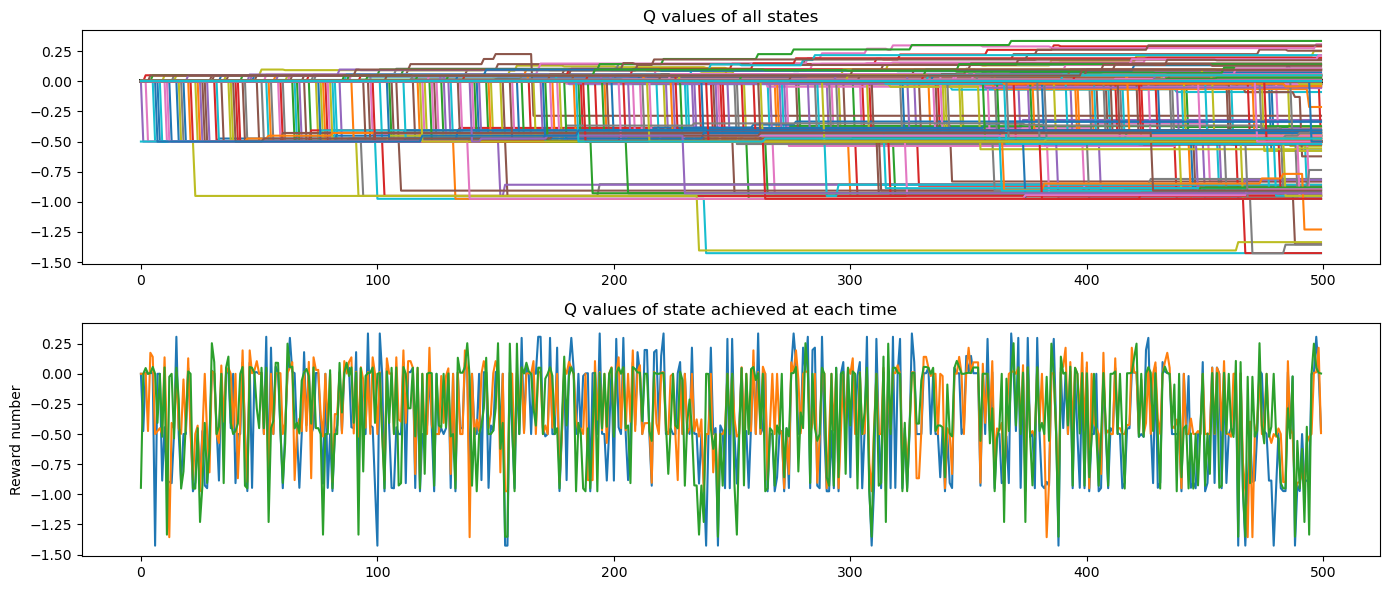

In [41]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,6),layout='tight')
ax = [ fig.add_subplot(2,1,x) for x in range(1,3) ]
ax[0].plot(np.arange(0,len(q_states)),Q)
ax[0].set_title('Q values of all states')
ax[1].plot(np.arange(0,len(q_states)),q_achieved)
ax[1].set_title('Q values of state achieved at each time')
ax[1].set_ylabel('Reward number')

OK, now let's try running it for a much longer period -- say, 5000 complete games.  We won't ask it to print out any states this time.

In [42]:
scores, q_achieved, q_states = pong_game.run(m_games=5000, states=[])

print('The number of games played was',len(scores))
print('The number of video frames was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 15 rewards, 7161 frames, score 14, max score 14
Completed 1 games, 16 rewards, 7415 frames, score 0, max score 14
Completed 2 games, 17 rewards, 7669 frames, score 0, max score 14
Completed 3 games, 19 rewards, 8106 frames, score 1, max score 14
Completed 4 games, 21 rewards, 8447 frames, score 1, max score 14
Completed 5 games, 22 rewards, 8628 frames, score 0, max score 14
Completed 6 games, 23 rewards, 8882 frames, score 0, max score 14
Completed 7 games, 25 rewards, 9319 frames, score 1, max score 14
Completed 8 games, 26 rewards, 9500 frames, score 0, max score 14
Completed 9 games, 27 rewards, 9754 frames, score 0, max score 14
Completed 10 games, 32 rewards, 11177 frames, score 4, max score 14
Completed 11 games, 34 rewards, 11577 frames, score 1, max score 14
Completed 12 games, 35 rewards, 11831 frames, score 0, max score 14
Completed 13 games, 36 rewards, 12039 frames, score 0, max score 14
Completed 14 games, 37 rewards, 12247 frames, score 0, max score 14

Completed 125 games, 267 rewards, 71571 frames, score 1, max score 14
Completed 126 games, 268 rewards, 71825 frames, score 0, max score 14
Completed 127 games, 269 rewards, 72006 frames, score 0, max score 14
Completed 128 games, 274 rewards, 73111 frames, score 4, max score 14
Completed 129 games, 277 rewards, 73704 frames, score 2, max score 14
Completed 130 games, 282 rewards, 75984 frames, score 4, max score 14
Completed 131 games, 285 rewards, 76548 frames, score 2, max score 14
Completed 132 games, 287 rewards, 77008 frames, score 1, max score 14
Completed 133 games, 289 rewards, 77598 frames, score 1, max score 14
Completed 134 games, 293 rewards, 78624 frames, score 3, max score 14
Completed 135 games, 294 rewards, 78805 frames, score 0, max score 14
Completed 136 games, 295 rewards, 78986 frames, score 0, max score 14
Completed 137 games, 297 rewards, 79648 frames, score 1, max score 14
Completed 138 games, 301 rewards, 80518 frames, score 3, max score 14
Completed 139 games,

Completed 250 games, 531 rewards, 135700 frames, score 0, max score 14
Completed 251 games, 532 rewards, 135908 frames, score 0, max score 14
Completed 252 games, 541 rewards, 141403 frames, score 8, max score 14
Completed 253 games, 544 rewards, 143261 frames, score 2, max score 14
Completed 254 games, 545 rewards, 143469 frames, score 0, max score 14
Completed 255 games, 547 rewards, 143952 frames, score 1, max score 14
Completed 256 games, 548 rewards, 144206 frames, score 0, max score 14
Completed 257 games, 554 rewards, 145177 frames, score 5, max score 14
Completed 258 games, 556 rewards, 145637 frames, score 1, max score 14
Completed 259 games, 559 rewards, 146213 frames, score 2, max score 14
Completed 260 games, 561 rewards, 146600 frames, score 1, max score 14
Completed 261 games, 562 rewards, 146808 frames, score 0, max score 14
Completed 262 games, 563 rewards, 146989 frames, score 0, max score 14
Completed 263 games, 565 rewards, 147313 frames, score 1, max score 14
Comple

Completed 454 games, 990 rewards, 256757 frames, score 2, max score 14
Completed 455 games, 992 rewards, 257347 frames, score 1, max score 14
Completed 456 games, 993 rewards, 257528 frames, score 0, max score 14
Completed 457 games, 996 rewards, 258030 frames, score 2, max score 14
Completed 458 games, 999 rewards, 258628 frames, score 2, max score 14
Completed 459 games, 1002 rewards, 259318 frames, score 2, max score 14
Completed 460 games, 1004 rewards, 260237 frames, score 1, max score 14
Completed 461 games, 1007 rewards, 261059 frames, score 2, max score 14
Completed 462 games, 1010 rewards, 261661 frames, score 2, max score 14
Completed 463 games, 1015 rewards, 263295 frames, score 4, max score 14
Completed 464 games, 1018 rewards, 264019 frames, score 2, max score 14
Completed 465 games, 1022 rewards, 264792 frames, score 3, max score 14
Completed 466 games, 1024 rewards, 265201 frames, score 1, max score 14
Completed 467 games, 1026 rewards, 265638 frames, score 1, max score 

Completed 658 games, 1587 rewards, 412034 frames, score 11, max score 14
Completed 659 games, 1588 rewards, 412215 frames, score 0, max score 14
Completed 660 games, 1595 rewards, 413415 frames, score 6, max score 14
Completed 661 games, 1597 rewards, 413820 frames, score 1, max score 14
Completed 662 games, 1605 rewards, 417662 frames, score 7, max score 14
Completed 663 games, 1608 rewards, 418547 frames, score 2, max score 14
Completed 664 games, 1611 rewards, 419055 frames, score 2, max score 14
Completed 665 games, 1612 rewards, 419309 frames, score 0, max score 14
Completed 666 games, 1614 rewards, 419971 frames, score 1, max score 14
Completed 667 games, 1618 rewards, 420740 frames, score 3, max score 14
Completed 668 games, 1622 rewards, 421498 frames, score 3, max score 14
Completed 669 games, 1627 rewards, 425358 frames, score 4, max score 14
Completed 670 games, 1629 rewards, 425870 frames, score 1, max score 14
Completed 671 games, 1630 rewards, 426124 frames, score 0, max 

Completed 785 games, 2018 rewards, 516244 frames, score 4, max score 14
Completed 786 games, 2020 rewards, 516732 frames, score 1, max score 14
Completed 787 games, 2021 rewards, 516940 frames, score 0, max score 14
Completed 788 games, 2022 rewards, 517148 frames, score 0, max score 14
Completed 789 games, 2024 rewards, 517558 frames, score 1, max score 14
Completed 790 games, 2029 rewards, 518437 frames, score 4, max score 14
Completed 791 games, 2031 rewards, 518925 frames, score 1, max score 14
Completed 792 games, 2036 rewards, 519898 frames, score 4, max score 14
Completed 793 games, 2038 rewards, 520309 frames, score 1, max score 14
Completed 794 games, 2041 rewards, 520863 frames, score 2, max score 14
Completed 795 games, 2045 rewards, 522533 frames, score 3, max score 14
Completed 796 games, 2046 rewards, 522741 frames, score 0, max score 14
Completed 797 games, 2051 rewards, 524007 frames, score 4, max score 14
Completed 798 games, 2052 rewards, 524215 frames, score 0, max s

Completed 907 games, 2465 rewards, 625205 frames, score 6, max score 21
Completed 908 games, 2472 rewards, 626444 frames, score 6, max score 21
Completed 909 games, 2497 rewards, 630638 frames, score 24, max score 24
Completed 910 games, 2498 rewards, 630819 frames, score 0, max score 24
Completed 911 games, 2501 rewards, 632677 frames, score 2, max score 24
Completed 912 games, 2515 rewards, 635849 frames, score 13, max score 24
Completed 913 games, 2521 rewards, 636911 frames, score 5, max score 24
Completed 914 games, 2525 rewards, 638707 frames, score 3, max score 24
Completed 915 games, 2530 rewards, 639778 frames, score 4, max score 24
Completed 916 games, 2535 rewards, 641023 frames, score 4, max score 24
Completed 917 games, 2540 rewards, 641843 frames, score 4, max score 24
Completed 918 games, 2542 rewards, 642303 frames, score 1, max score 24
Completed 919 games, 2543 rewards, 642557 frames, score 0, max score 24
Completed 920 games, 2553 rewards, 645846 frames, score 9, max

Completed 1029 games, 3016 rewards, 760526 frames, score 7, max score 24
Completed 1030 games, 3018 rewards, 761128 frames, score 1, max score 24
Completed 1031 games, 3023 rewards, 762481 frames, score 4, max score 24
Completed 1032 games, 3026 rewards, 763128 frames, score 2, max score 24
Completed 1033 games, 3031 rewards, 764062 frames, score 4, max score 24
Completed 1034 games, 3035 rewards, 764829 frames, score 3, max score 24
Completed 1035 games, 3040 rewards, 765896 frames, score 4, max score 24
Completed 1036 games, 3046 rewards, 767108 frames, score 5, max score 24
Completed 1037 games, 3051 rewards, 768427 frames, score 4, max score 24
Completed 1038 games, 3052 rewards, 768608 frames, score 0, max score 24
Completed 1039 games, 3059 rewards, 769480 frames, score 6, max score 24
Completed 1040 games, 3062 rewards, 770006 frames, score 2, max score 24
Completed 1041 games, 3064 rewards, 770518 frames, score 1, max score 24
Completed 1042 games, 3067 rewards, 771002 frames, 

Completed 1142 games, 3454 rewards, 872881 frames, score 8, max score 24
Completed 1143 games, 3455 rewards, 873062 frames, score 0, max score 24
Completed 1144 games, 3457 rewards, 873403 frames, score 1, max score 24
Completed 1145 games, 3462 rewards, 874464 frames, score 4, max score 24
Completed 1146 games, 3471 rewards, 875993 frames, score 8, max score 24
Completed 1147 games, 3474 rewards, 876661 frames, score 2, max score 24
Completed 1148 games, 3482 rewards, 878546 frames, score 7, max score 24
Completed 1149 games, 3484 rewards, 878983 frames, score 1, max score 24
Completed 1150 games, 3486 rewards, 879443 frames, score 1, max score 24
Completed 1151 games, 3490 rewards, 880072 frames, score 3, max score 24
Completed 1152 games, 3501 rewards, 885948 frames, score 10, max score 24
Completed 1153 games, 3511 rewards, 887882 frames, score 9, max score 24
Completed 1154 games, 3514 rewards, 888712 frames, score 2, max score 24
Completed 1155 games, 3519 rewards, 889961 frames,

Completed 1269 games, 4149 rewards, 1091380 frames, score 10, max score 28
Completed 1270 games, 4150 rewards, 1091634 frames, score 0, max score 28
Completed 1271 games, 4159 rewards, 1093104 frames, score 8, max score 28
Completed 1272 games, 4167 rewards, 1094451 frames, score 7, max score 28
Completed 1273 games, 4171 rewards, 1096694 frames, score 3, max score 28
Completed 1274 games, 4182 rewards, 1100910 frames, score 10, max score 28
Completed 1275 games, 4189 rewards, 1102580 frames, score 6, max score 28
Completed 1276 games, 4190 rewards, 1102834 frames, score 0, max score 28
Completed 1277 games, 4193 rewards, 1103454 frames, score 2, max score 28
Completed 1278 games, 4216 rewards, 1107332 frames, score 22, max score 28
Completed 1279 games, 4220 rewards, 1109086 frames, score 3, max score 28
Completed 1280 games, 4226 rewards, 1109924 frames, score 5, max score 28
Completed 1281 games, 4230 rewards, 1110855 frames, score 3, max score 28
Completed 1282 games, 4235 rewards,

Completed 1414 games, 4913 rewards, 1293381 frames, score 8, max score 47
Completed 1415 games, 4919 rewards, 1296336 frames, score 5, max score 47
Completed 1416 games, 4933 rewards, 1300236 frames, score 13, max score 47
Completed 1417 games, 4937 rewards, 1301072 frames, score 3, max score 47
Completed 1418 games, 4940 rewards, 1301700 frames, score 2, max score 47
Completed 1419 games, 4948 rewards, 1303640 frames, score 7, max score 47
Completed 1420 games, 4978 rewards, 1316454 frames, score 29, max score 47
Completed 1421 games, 4980 rewards, 1316917 frames, score 1, max score 47
Completed 1422 games, 4984 rewards, 1317645 frames, score 3, max score 47
Completed 1423 games, 4988 rewards, 1318529 frames, score 3, max score 47
Completed 1424 games, 4992 rewards, 1319157 frames, score 3, max score 47
Completed 1425 games, 4993 rewards, 1319365 frames, score 0, max score 47
Completed 1426 games, 4998 rewards, 1320287 frames, score 4, max score 47
Completed 1427 games, 4999 rewards, 

Completed 1551 games, 5552 rewards, 1466103 frames, score 2, max score 47
Completed 1552 games, 5555 rewards, 1467057 frames, score 2, max score 47
Completed 1553 games, 5556 rewards, 1467311 frames, score 0, max score 47
Completed 1554 games, 5558 rewards, 1467808 frames, score 1, max score 47
Completed 1555 games, 5564 rewards, 1469133 frames, score 5, max score 47
Completed 1556 games, 5573 rewards, 1472810 frames, score 8, max score 47
Completed 1557 games, 5577 rewards, 1473836 frames, score 3, max score 47
Completed 1558 games, 5579 rewards, 1474370 frames, score 1, max score 47
Completed 1559 games, 5581 rewards, 1474882 frames, score 1, max score 47
Completed 1560 games, 5588 rewards, 1476416 frames, score 6, max score 47
Completed 1561 games, 5591 rewards, 1477658 frames, score 2, max score 47
Completed 1562 games, 5593 rewards, 1478063 frames, score 1, max score 47
Completed 1563 games, 5598 rewards, 1479352 frames, score 4, max score 47
Completed 1564 games, 5600 rewards, 14

Completed 1673 games, 6439 rewards, 1686505 frames, score 17, max score 47
Completed 1674 games, 6446 rewards, 1689166 frames, score 6, max score 47
Completed 1675 games, 6464 rewards, 1696257 frames, score 17, max score 47
Completed 1676 games, 6472 rewards, 1697665 frames, score 7, max score 47
Completed 1677 games, 6478 rewards, 1698681 frames, score 5, max score 47
Completed 1678 games, 6486 rewards, 1700147 frames, score 7, max score 47
Completed 1679 games, 6491 rewards, 1701705 frames, score 4, max score 47
Completed 1680 games, 6503 rewards, 1705047 frames, score 11, max score 47
Completed 1681 games, 6520 rewards, 1711880 frames, score 16, max score 47
Completed 1682 games, 6521 rewards, 1712088 frames, score 0, max score 47
Completed 1683 games, 6540 rewards, 1715205 frames, score 18, max score 47
Completed 1684 games, 6548 rewards, 1716749 frames, score 7, max score 47
Completed 1685 games, 6555 rewards, 1718440 frames, score 6, max score 47
Completed 1686 games, 6565 reward

Completed 1806 games, 7296 rewards, 1899936 frames, score 4, max score 47
Completed 1807 games, 7304 rewards, 1901363 frames, score 7, max score 47
Completed 1808 games, 7306 rewards, 1901807 frames, score 1, max score 47
Completed 1809 games, 7318 rewards, 1903678 frames, score 11, max score 47
Completed 1810 games, 7322 rewards, 1904504 frames, score 3, max score 47
Completed 1811 games, 7325 rewards, 1905305 frames, score 2, max score 47
Completed 1812 games, 7331 rewards, 1906769 frames, score 5, max score 47
Completed 1813 games, 7336 rewards, 1907806 frames, score 4, max score 47
Completed 1814 games, 7346 rewards, 1910017 frames, score 9, max score 47
Completed 1815 games, 7352 rewards, 1911518 frames, score 5, max score 47
Completed 1816 games, 7354 rewards, 1912180 frames, score 1, max score 47
Completed 1817 games, 7355 rewards, 1912388 frames, score 0, max score 47
Completed 1818 games, 7361 rewards, 1913394 frames, score 5, max score 47
Completed 1819 games, 7363 rewards, 1

Completed 1922 games, 8278 rewards, 2137444 frames, score 29, max score 47
Completed 1923 games, 8312 rewards, 2146196 frames, score 33, max score 47
Completed 1924 games, 8335 rewards, 2154858 frames, score 22, max score 47
Completed 1925 games, 8367 rewards, 2166003 frames, score 31, max score 47
Completed 1926 games, 8375 rewards, 2167754 frames, score 7, max score 47
Completed 1927 games, 8387 rewards, 2170166 frames, score 11, max score 47
Completed 1928 games, 8393 rewards, 2172543 frames, score 5, max score 47
Completed 1929 games, 8408 rewards, 2175546 frames, score 14, max score 47
Completed 1930 games, 8416 rewards, 2176790 frames, score 7, max score 47
Completed 1931 games, 8420 rewards, 2177864 frames, score 3, max score 47
Completed 1932 games, 8434 rewards, 2180498 frames, score 13, max score 47
Completed 1933 games, 8443 rewards, 2182139 frames, score 8, max score 47
Completed 1934 games, 8448 rewards, 2183012 frames, score 4, max score 47
Completed 1935 games, 8451 rewa

Completed 2051 games, 9583 rewards, 2458484 frames, score 6, max score 47
Completed 2052 games, 9585 rewards, 2458836 frames, score 1, max score 47
Completed 2053 games, 9589 rewards, 2459736 frames, score 3, max score 47
Completed 2054 games, 9596 rewards, 2461469 frames, score 6, max score 47
Completed 2055 games, 9604 rewards, 2464120 frames, score 7, max score 47
Completed 2056 games, 9612 rewards, 2465993 frames, score 7, max score 47
Completed 2057 games, 9623 rewards, 2468087 frames, score 10, max score 47
Completed 2058 games, 9633 rewards, 2470152 frames, score 9, max score 47
Completed 2059 games, 9642 rewards, 2473621 frames, score 8, max score 47
Completed 2060 games, 9645 rewards, 2474255 frames, score 2, max score 47
Completed 2061 games, 9650 rewards, 2475043 frames, score 4, max score 47
Completed 2062 games, 9656 rewards, 2476221 frames, score 5, max score 47
Completed 2063 games, 9657 rewards, 2476429 frames, score 0, max score 47
Completed 2064 games, 9662 rewards, 2

Completed 2191 games, 10358 rewards, 2648052 frames, score 12, max score 53
Completed 2192 games, 10372 rewards, 2650284 frames, score 13, max score 53
Completed 2193 games, 10390 rewards, 2655628 frames, score 17, max score 53
Completed 2194 games, 10395 rewards, 2656626 frames, score 4, max score 53
Completed 2195 games, 10402 rewards, 2657973 frames, score 6, max score 53
Completed 2196 games, 10413 rewards, 2660226 frames, score 10, max score 53
Completed 2197 games, 10442 rewards, 2668534 frames, score 28, max score 53
Completed 2198 games, 10463 rewards, 2671962 frames, score 20, max score 53
Completed 2199 games, 10469 rewards, 2672908 frames, score 5, max score 53
Completed 2200 games, 10488 rewards, 2678170 frames, score 18, max score 53
Completed 2201 games, 10491 rewards, 2678832 frames, score 2, max score 53
Completed 2202 games, 10497 rewards, 2680345 frames, score 5, max score 53
Completed 2203 games, 10498 rewards, 2680553 frames, score 0, max score 53
Completed 2204 gam

Completed 2302 games, 11415 rewards, 2897623 frames, score 37, max score 53
Completed 2303 games, 11436 rewards, 2901810 frames, score 20, max score 53
Completed 2304 games, 11444 rewards, 2904150 frames, score 7, max score 53
Completed 2305 games, 11460 rewards, 2908012 frames, score 15, max score 53
Completed 2306 games, 11479 rewards, 2911554 frames, score 18, max score 53
Completed 2307 games, 11489 rewards, 2913559 frames, score 9, max score 53
Completed 2308 games, 11509 rewards, 2916635 frames, score 19, max score 53
Completed 2309 games, 11525 rewards, 2919915 frames, score 15, max score 53
Completed 2310 games, 11527 rewards, 2920375 frames, score 1, max score 53
Completed 2311 games, 11532 rewards, 2921144 frames, score 4, max score 53
Completed 2312 games, 11543 rewards, 2923984 frames, score 10, max score 53
Completed 2313 games, 11549 rewards, 2925317 frames, score 5, max score 53
Completed 2314 games, 11559 rewards, 2927834 frames, score 9, max score 53
Completed 2315 gam

Completed 2418 games, 12642 rewards, 3200500 frames, score 27, max score 53
Completed 2419 games, 12651 rewards, 3202745 frames, score 8, max score 53
Completed 2420 games, 12660 rewards, 3207031 frames, score 8, max score 53
Completed 2421 games, 12676 rewards, 3210746 frames, score 15, max score 53
Completed 2422 games, 12701 rewards, 3214749 frames, score 24, max score 53
Completed 2423 games, 12708 rewards, 3216308 frames, score 6, max score 53
Completed 2424 games, 12715 rewards, 3217988 frames, score 6, max score 53
Completed 2425 games, 12726 rewards, 3219675 frames, score 10, max score 53
Completed 2426 games, 12730 rewards, 3221716 frames, score 3, max score 53
Completed 2427 games, 12736 rewards, 3223066 frames, score 5, max score 53
Completed 2428 games, 12763 rewards, 3227411 frames, score 26, max score 53
Completed 2429 games, 12772 rewards, 3228740 frames, score 8, max score 53
Completed 2430 games, 12784 rewards, 3230824 frames, score 11, max score 53
Completed 2431 game

Completed 2533 games, 14147 rewards, 3541360 frames, score 13, max score 80
Completed 2534 games, 14187 rewards, 3549141 frames, score 39, max score 80
Completed 2535 games, 14226 rewards, 3555564 frames, score 38, max score 80
Completed 2536 games, 14246 rewards, 3559468 frames, score 19, max score 80
Completed 2537 games, 14266 rewards, 3567533 frames, score 19, max score 80
Completed 2538 games, 14277 rewards, 3570097 frames, score 10, max score 80
Completed 2539 games, 14314 rewards, 3576298 frames, score 36, max score 80
Completed 2540 games, 14344 rewards, 3580864 frames, score 29, max score 80
Completed 2541 games, 14359 rewards, 3583743 frames, score 14, max score 80
Completed 2542 games, 14368 rewards, 3585208 frames, score 8, max score 80
Completed 2543 games, 14373 rewards, 3586670 frames, score 4, max score 80
Completed 2544 games, 14385 rewards, 3589113 frames, score 11, max score 80
Completed 2545 games, 14453 rewards, 3603045 frames, score 67, max score 80
Completed 2546

Completed 2651 games, 16865 rewards, 4124233 frames, score 15, max score 140
Completed 2652 games, 16880 rewards, 4126857 frames, score 14, max score 140
Completed 2653 games, 16886 rewards, 4127827 frames, score 5, max score 140
Completed 2654 games, 16895 rewards, 4129702 frames, score 8, max score 140
Completed 2655 games, 16925 rewards, 4134801 frames, score 29, max score 140
Completed 2656 games, 16937 rewards, 4137070 frames, score 11, max score 140
Completed 2657 games, 16940 rewards, 4137728 frames, score 2, max score 140
Completed 2658 games, 17025 rewards, 4157823 frames, score 84, max score 140
Completed 2659 games, 17035 rewards, 4163608 frames, score 9, max score 140
Completed 2660 games, 17041 rewards, 4164758 frames, score 5, max score 140
Completed 2661 games, 17045 rewards, 4165601 frames, score 3, max score 140
Completed 2662 games, 17057 rewards, 4168158 frames, score 11, max score 140
Completed 2663 games, 17079 rewards, 4171854 frames, score 21, max score 140
Compl

Completed 2761 games, 18518 rewards, 4518791 frames, score 11, max score 140
Completed 2762 games, 18530 rewards, 4521213 frames, score 11, max score 140
Completed 2763 games, 18547 rewards, 4524003 frames, score 16, max score 140
Completed 2764 games, 18551 rewards, 4524640 frames, score 3, max score 140
Completed 2765 games, 18572 rewards, 4528070 frames, score 20, max score 140
Completed 2766 games, 18578 rewards, 4531735 frames, score 5, max score 140
Completed 2767 games, 18590 rewards, 4536417 frames, score 11, max score 140
Completed 2768 games, 18592 rewards, 4536823 frames, score 1, max score 140
Completed 2769 games, 18593 rewards, 4537077 frames, score 0, max score 140
Completed 2770 games, 18600 rewards, 4538860 frames, score 6, max score 140
Completed 2771 games, 18607 rewards, 4540578 frames, score 6, max score 140
Completed 2772 games, 18615 rewards, 4542045 frames, score 7, max score 140
Completed 2773 games, 18620 rewards, 4543025 frames, score 4, max score 140
Complet

Completed 2870 games, 19561 rewards, 4789295 frames, score 42, max score 140
Completed 2871 games, 19570 rewards, 4790846 frames, score 8, max score 140
Completed 2872 games, 19583 rewards, 4793006 frames, score 12, max score 140
Completed 2873 games, 19594 rewards, 4795334 frames, score 10, max score 140
Completed 2874 games, 19596 rewards, 4795740 frames, score 1, max score 140
Completed 2875 games, 19604 rewards, 4796960 frames, score 7, max score 140
Completed 2876 games, 19616 rewards, 4798975 frames, score 11, max score 140
Completed 2877 games, 19624 rewards, 4801094 frames, score 7, max score 140
Completed 2878 games, 19625 rewards, 4801302 frames, score 0, max score 140
Completed 2879 games, 19627 rewards, 4801964 frames, score 1, max score 140
Completed 2880 games, 19635 rewards, 4803610 frames, score 7, max score 140
Completed 2881 games, 19646 rewards, 4805805 frames, score 10, max score 140
Completed 2882 games, 19647 rewards, 4805986 frames, score 0, max score 140
Complet

Completed 2988 games, 20787 rewards, 5111548 frames, score 35, max score 140
Completed 2989 games, 20803 rewards, 5115868 frames, score 15, max score 140
Completed 2990 games, 20819 rewards, 5118672 frames, score 15, max score 140
Completed 2991 games, 20826 rewards, 5121082 frames, score 6, max score 140
Completed 2992 games, 20834 rewards, 5122445 frames, score 7, max score 140
Completed 2993 games, 20838 rewards, 5123174 frames, score 3, max score 140
Completed 2994 games, 20862 rewards, 5127769 frames, score 23, max score 140
Completed 2995 games, 20874 rewards, 5129777 frames, score 11, max score 140
Completed 2996 games, 20877 rewards, 5130284 frames, score 2, max score 140
Completed 2997 games, 20884 rewards, 5131348 frames, score 6, max score 140
Completed 2998 games, 20921 rewards, 5144141 frames, score 36, max score 140
Completed 2999 games, 20929 rewards, 5147086 frames, score 7, max score 140
Completed 3000 games, 20936 rewards, 5148378 frames, score 6, max score 140
Comple

Completed 3103 games, 22013 rewards, 5446528 frames, score 2, max score 140
Completed 3104 games, 22023 rewards, 5448359 frames, score 9, max score 140
Completed 3105 games, 22024 rewards, 5448613 frames, score 0, max score 140
Completed 3106 games, 22026 rewards, 5449076 frames, score 1, max score 140
Completed 3107 games, 22031 rewards, 5450097 frames, score 4, max score 140
Completed 3108 games, 22034 rewards, 5450897 frames, score 2, max score 140
Completed 3109 games, 22044 rewards, 5453868 frames, score 9, max score 140
Completed 3110 games, 22052 rewards, 5455446 frames, score 7, max score 140
Completed 3111 games, 22055 rewards, 5456567 frames, score 2, max score 140
Completed 3112 games, 22057 rewards, 5457055 frames, score 1, max score 140
Completed 3113 games, 22060 rewards, 5457919 frames, score 2, max score 140
Completed 3114 games, 22089 rewards, 5463799 frames, score 28, max score 140
Completed 3115 games, 22090 rewards, 5463980 frames, score 0, max score 140
Completed 3

Completed 3219 games, 23360 rewards, 5742015 frames, score 100, max score 140
Completed 3220 games, 23385 rewards, 5746993 frames, score 24, max score 140
Completed 3221 games, 23429 rewards, 5755702 frames, score 43, max score 140
Completed 3222 games, 23438 rewards, 5757088 frames, score 8, max score 140
Completed 3223 games, 23441 rewards, 5757614 frames, score 2, max score 140
Completed 3224 games, 23453 rewards, 5760410 frames, score 11, max score 140
Completed 3225 games, 23479 rewards, 5767161 frames, score 25, max score 140
Completed 3226 games, 23523 rewards, 5792113 frames, score 43, max score 140
Completed 3227 games, 23580 rewards, 5802036 frames, score 56, max score 140
Completed 3228 games, 23598 rewards, 5805208 frames, score 17, max score 140
Completed 3229 games, 23611 rewards, 5807712 frames, score 12, max score 140
Completed 3230 games, 23614 rewards, 5808523 frames, score 2, max score 140
Completed 3231 games, 23730 rewards, 5831485 frames, score 115, max score 140


Completed 3329 games, 27606 rewards, 6588600 frames, score 94, max score 199
Completed 3330 games, 27622 rewards, 6593502 frames, score 15, max score 199
Completed 3331 games, 27707 rewards, 6609983 frames, score 84, max score 199
Completed 3332 games, 27727 rewards, 6613355 frames, score 19, max score 199
Completed 3333 games, 27760 rewards, 6627638 frames, score 32, max score 199
Completed 3334 games, 27846 rewards, 6642454 frames, score 85, max score 199
Completed 3335 games, 27883 rewards, 6650847 frames, score 36, max score 199
Completed 3336 games, 27920 rewards, 6656296 frames, score 36, max score 199
Completed 3337 games, 27965 rewards, 6663419 frames, score 44, max score 199
Completed 3338 games, 28012 rewards, 6677089 frames, score 46, max score 199
Completed 3339 games, 28033 rewards, 6681318 frames, score 20, max score 199
Completed 3340 games, 28038 rewards, 6682572 frames, score 4, max score 199
Completed 3341 games, 28062 rewards, 6687273 frames, score 23, max score 199


Completed 3436 games, 31252 rewards, 7317251 frames, score 47, max score 199
Completed 3437 games, 31256 rewards, 7318477 frames, score 3, max score 199
Completed 3438 games, 31281 rewards, 7323444 frames, score 24, max score 199
Completed 3439 games, 31282 rewards, 7323698 frames, score 0, max score 199
Completed 3440 games, 31288 rewards, 7324720 frames, score 5, max score 199
Completed 3441 games, 31298 rewards, 7328952 frames, score 9, max score 199
Completed 3442 games, 31312 rewards, 7331847 frames, score 13, max score 199
Completed 3443 games, 31320 rewards, 7336467 frames, score 7, max score 199
Completed 3444 games, 31322 rewards, 7336881 frames, score 1, max score 199
Completed 3445 games, 31393 rewards, 7369223 frames, score 70, max score 199
Completed 3446 games, 31397 rewards, 7369909 frames, score 3, max score 199
Completed 3447 games, 31419 rewards, 7374192 frames, score 21, max score 199
Completed 3448 games, 31422 rewards, 7375040 frames, score 2, max score 199
Complet

Completed 3544 games, 35270 rewards, 8116047 frames, score 53, max score 327
Completed 3545 games, 35282 rewards, 8118180 frames, score 11, max score 327
Completed 3546 games, 35428 rewards, 8148657 frames, score 145, max score 327
Completed 3547 games, 35671 rewards, 8188868 frames, score 242, max score 327
Completed 3548 games, 35756 rewards, 8202198 frames, score 84, max score 327
Completed 3549 games, 35971 rewards, 8240340 frames, score 214, max score 327
Completed 3550 games, 36098 rewards, 8263053 frames, score 126, max score 327
Completed 3551 games, 36103 rewards, 8264171 frames, score 4, max score 327
Completed 3552 games, 36263 rewards, 8288316 frames, score 159, max score 327
Completed 3553 games, 36315 rewards, 8296011 frames, score 51, max score 327
Completed 3554 games, 36330 rewards, 8300405 frames, score 14, max score 327
Completed 3555 games, 36447 rewards, 8318798 frames, score 116, max score 327
Completed 3556 games, 36527 rewards, 8339432 frames, score 79, max scor

Completed 3653 games, 43012 rewards, 9554673 frames, score 24, max score 338
Completed 3654 games, 43017 rewards, 9555663 frames, score 4, max score 338
Completed 3655 games, 43038 rewards, 9559700 frames, score 20, max score 338
Completed 3656 games, 43062 rewards, 9563305 frames, score 23, max score 338
Completed 3657 games, 43101 rewards, 9569704 frames, score 38, max score 338
Completed 3658 games, 43130 rewards, 9582074 frames, score 28, max score 338
Completed 3659 games, 43230 rewards, 9602242 frames, score 99, max score 338
Completed 3660 games, 43249 rewards, 9605586 frames, score 18, max score 338
Completed 3661 games, 43271 rewards, 9609493 frames, score 21, max score 338
Completed 3662 games, 43279 rewards, 9611922 frames, score 7, max score 338
Completed 3663 games, 43299 rewards, 9615717 frames, score 19, max score 338
Completed 3664 games, 43301 rewards, 9616100 frames, score 1, max score 338
Completed 3665 games, 43326 rewards, 9620158 frames, score 24, max score 338
Co

Completed 3767 games, 44661 rewards, 9928163 frames, score 33, max score 338
Completed 3768 games, 44673 rewards, 9930324 frames, score 11, max score 338
Completed 3769 games, 44675 rewards, 9930914 frames, score 1, max score 338
Completed 3770 games, 44689 rewards, 9935463 frames, score 13, max score 338
Completed 3771 games, 44738 rewards, 9951128 frames, score 48, max score 338
Completed 3772 games, 44751 rewards, 9953686 frames, score 12, max score 338
Completed 3773 games, 44760 rewards, 9956194 frames, score 8, max score 338
Completed 3774 games, 44764 rewards, 9956942 frames, score 3, max score 338
Completed 3775 games, 44774 rewards, 9959095 frames, score 9, max score 338
Completed 3776 games, 44804 rewards, 9966822 frames, score 29, max score 338
Completed 3777 games, 44817 rewards, 9969179 frames, score 12, max score 338
Completed 3778 games, 44825 rewards, 9970719 frames, score 7, max score 338
Completed 3779 games, 44832 rewards, 9972022 frames, score 6, max score 338
Compl

Completed 3874 games, 45896 rewards, 10224177 frames, score 14, max score 338
Completed 3875 games, 45899 rewards, 10224908 frames, score 2, max score 338
Completed 3876 games, 45917 rewards, 10228367 frames, score 17, max score 338
Completed 3877 games, 45971 rewards, 10246752 frames, score 53, max score 338
Completed 3878 games, 45976 rewards, 10247684 frames, score 4, max score 338
Completed 3879 games, 45986 rewards, 10251863 frames, score 9, max score 338
Completed 3880 games, 46003 rewards, 10258131 frames, score 16, max score 338
Completed 3881 games, 46026 rewards, 10263997 frames, score 22, max score 338
Completed 3882 games, 46029 rewards, 10264647 frames, score 2, max score 338
Completed 3883 games, 46041 rewards, 10270497 frames, score 11, max score 338
Completed 3884 games, 46043 rewards, 10270849 frames, score 1, max score 338
Completed 3885 games, 46045 rewards, 10271312 frames, score 1, max score 338
Completed 3886 games, 46064 rewards, 10280280 frames, score 18, max sc

Completed 3985 games, 46979 rewards, 10515760 frames, score 3, max score 338
Completed 3986 games, 46981 rewards, 10516422 frames, score 1, max score 338
Completed 3987 games, 46983 rewards, 10516828 frames, score 1, max score 338
Completed 3988 games, 46988 rewards, 10517931 frames, score 4, max score 338
Completed 3989 games, 46995 rewards, 10519335 frames, score 6, max score 338
Completed 3990 games, 46996 rewards, 10519516 frames, score 0, max score 338
Completed 3991 games, 47001 rewards, 10520964 frames, score 4, max score 338
Completed 3992 games, 47006 rewards, 10521866 frames, score 4, max score 338
Completed 3993 games, 47007 rewards, 10522120 frames, score 0, max score 338
Completed 3994 games, 47011 rewards, 10522831 frames, score 3, max score 338
Completed 3995 games, 47012 rewards, 10523039 frames, score 0, max score 338
Completed 3996 games, 47020 rewards, 10524579 frames, score 7, max score 338
Completed 3997 games, 47026 rewards, 10525850 frames, score 5, max score 338

Completed 4102 games, 47942 rewards, 10759131 frames, score 10, max score 338
Completed 4103 games, 47943 rewards, 10759312 frames, score 0, max score 338
Completed 4104 games, 47944 rewards, 10759493 frames, score 0, max score 338
Completed 4105 games, 47955 rewards, 10762351 frames, score 10, max score 338
Completed 4106 games, 47956 rewards, 10762559 frames, score 0, max score 338
Completed 4107 games, 47960 rewards, 10763267 frames, score 3, max score 338
Completed 4108 games, 47967 rewards, 10764849 frames, score 6, max score 338
Completed 4109 games, 47968 rewards, 10765057 frames, score 0, max score 338
Completed 4110 games, 47975 rewards, 10766450 frames, score 6, max score 338
Completed 4111 games, 47981 rewards, 10768196 frames, score 5, max score 338
Completed 4112 games, 48002 rewards, 10774252 frames, score 20, max score 338
Completed 4113 games, 48005 rewards, 10774978 frames, score 2, max score 338
Completed 4114 games, 48014 rewards, 10776466 frames, score 8, max score 

Completed 4210 games, 48998 rewards, 11012266 frames, score 14, max score 338
Completed 4211 games, 49004 rewards, 11013186 frames, score 5, max score 338
Completed 4212 games, 49008 rewards, 11014391 frames, score 3, max score 338
Completed 4213 games, 49018 rewards, 11017046 frames, score 9, max score 338
Completed 4214 games, 49023 rewards, 11017968 frames, score 4, max score 338
Completed 4215 games, 49037 rewards, 11027747 frames, score 13, max score 338
Completed 4216 games, 49044 rewards, 11029919 frames, score 6, max score 338
Completed 4217 games, 49053 rewards, 11031887 frames, score 8, max score 338
Completed 4218 games, 49057 rewards, 11032830 frames, score 3, max score 338
Completed 4219 games, 49062 rewards, 11033920 frames, score 4, max score 338
Completed 4220 games, 49081 rewards, 11039492 frames, score 18, max score 338
Completed 4221 games, 49098 rewards, 11042642 frames, score 16, max score 338
Completed 4222 games, 49104 rewards, 11044024 frames, score 5, max score

Completed 4319 games, 50288 rewards, 11350181 frames, score 20, max score 338
Completed 4320 games, 50303 rewards, 11353629 frames, score 14, max score 338
Completed 4321 games, 50330 rewards, 11359906 frames, score 26, max score 338
Completed 4322 games, 50359 rewards, 11364456 frames, score 28, max score 338
Completed 4323 games, 50371 rewards, 11366576 frames, score 11, max score 338
Completed 4324 games, 50375 rewards, 11367343 frames, score 3, max score 338
Completed 4325 games, 50403 rewards, 11377499 frames, score 27, max score 338
Completed 4326 games, 50440 rewards, 11383256 frames, score 36, max score 338
Completed 4327 games, 50460 rewards, 11386628 frames, score 19, max score 338
Completed 4328 games, 50471 rewards, 11391609 frames, score 10, max score 338
Completed 4329 games, 50479 rewards, 11393055 frames, score 7, max score 338
Completed 4330 games, 50481 rewards, 11393460 frames, score 1, max score 338
Completed 4331 games, 50497 rewards, 11397436 frames, score 15, max

Completed 4433 games, 52608 rewards, 11865383 frames, score 60, max score 338
Completed 4434 games, 52633 rewards, 11871279 frames, score 24, max score 338
Completed 4435 games, 52636 rewards, 11871976 frames, score 2, max score 338
Completed 4436 games, 52677 rewards, 11886404 frames, score 40, max score 338
Completed 4437 games, 52723 rewards, 11897320 frames, score 45, max score 338
Completed 4438 games, 52728 rewards, 11898268 frames, score 4, max score 338
Completed 4439 games, 52736 rewards, 11899631 frames, score 7, max score 338
Completed 4440 games, 52772 rewards, 11905526 frames, score 35, max score 338
Completed 4441 games, 52775 rewards, 11906128 frames, score 2, max score 338
Completed 4442 games, 52780 rewards, 11907061 frames, score 4, max score 338
Completed 4443 games, 52803 rewards, 11919763 frames, score 22, max score 338
Completed 4444 games, 52816 rewards, 11922110 frames, score 12, max score 338
Completed 4445 games, 52849 rewards, 11927472 frames, score 32, max s

Completed 4538 games, 68071 rewards, 14630827 frames, score 9, max score 912
Completed 4539 games, 68087 rewards, 14633418 frames, score 15, max score 912
Completed 4540 games, 68214 rewards, 14654414 frames, score 126, max score 912
Completed 4541 games, 68324 rewards, 14677909 frames, score 109, max score 912
Completed 4542 games, 68390 rewards, 14688656 frames, score 65, max score 912
Completed 4543 games, 68397 rewards, 14689739 frames, score 6, max score 912
Completed 4544 games, 68418 rewards, 14693192 frames, score 20, max score 912
Completed 4545 games, 68438 rewards, 14697143 frames, score 19, max score 912
Completed 4546 games, 68457 rewards, 14700087 frames, score 18, max score 912
Completed 4547 games, 68638 rewards, 14731368 frames, score 180, max score 912
Completed 4548 games, 68668 rewards, 14738751 frames, score 29, max score 912
Completed 4549 games, 68679 rewards, 14743756 frames, score 10, max score 912
Completed 4550 games, 68711 rewards, 14749087 frames, score 31,

Completed 4657 games, 71961 rewards, 15414493 frames, score 44, max score 912
Completed 4658 games, 71983 rewards, 15417824 frames, score 21, max score 912
Completed 4659 games, 71986 rewards, 15418319 frames, score 2, max score 912
Completed 4660 games, 72011 rewards, 15422068 frames, score 24, max score 912
Completed 4661 games, 72044 rewards, 15427871 frames, score 32, max score 912
Completed 4662 games, 72089 rewards, 15435004 frames, score 44, max score 912
Completed 4663 games, 72107 rewards, 15439181 frames, score 17, max score 912
Completed 4664 games, 72121 rewards, 15441464 frames, score 13, max score 912
Completed 4665 games, 72129 rewards, 15445292 frames, score 7, max score 912
Completed 4666 games, 72155 rewards, 15449896 frames, score 25, max score 912
Completed 4667 games, 72181 rewards, 15454870 frames, score 25, max score 912
Completed 4668 games, 72219 rewards, 15461445 frames, score 37, max score 912
Completed 4669 games, 72235 rewards, 15464038 frames, score 15, ma

Completed 4766 games, 74153 rewards, 15886688 frames, score 19, max score 912
Completed 4767 games, 74162 rewards, 15889855 frames, score 8, max score 912
Completed 4768 games, 74201 rewards, 15900290 frames, score 38, max score 912
Completed 4769 games, 74231 rewards, 15905168 frames, score 29, max score 912
Completed 4770 games, 74242 rewards, 15907306 frames, score 10, max score 912
Completed 4771 games, 74257 rewards, 15910021 frames, score 14, max score 912
Completed 4772 games, 74264 rewards, 15911634 frames, score 6, max score 912
Completed 4773 games, 74278 rewards, 15914417 frames, score 13, max score 912
Completed 4774 games, 74280 rewards, 15914815 frames, score 1, max score 912
Completed 4775 games, 74281 rewards, 15915023 frames, score 0, max score 912
Completed 4776 games, 74289 rewards, 15916714 frames, score 7, max score 912
Completed 4777 games, 74291 rewards, 15917120 frames, score 1, max score 912
Completed 4778 games, 74310 rewards, 15920170 frames, score 18, max sc

Completed 4876 games, 75426 rewards, 16184771 frames, score 7, max score 912
Completed 4877 games, 75441 rewards, 16187449 frames, score 14, max score 912
Completed 4878 games, 75445 rewards, 16188134 frames, score 3, max score 912
Completed 4879 games, 75451 rewards, 16189847 frames, score 5, max score 912
Completed 4880 games, 75460 rewards, 16191538 frames, score 8, max score 912
Completed 4881 games, 75463 rewards, 16192158 frames, score 2, max score 912
Completed 4882 games, 75465 rewards, 16192618 frames, score 1, max score 912
Completed 4883 games, 75493 rewards, 16197742 frames, score 27, max score 912
Completed 4884 games, 75498 rewards, 16198999 frames, score 4, max score 912
Completed 4885 games, 75510 rewards, 16204089 frames, score 11, max score 912
Completed 4886 games, 75515 rewards, 16204946 frames, score 4, max score 912
Completed 4887 games, 75534 rewards, 16209847 frames, score 18, max score 912
Completed 4888 games, 75546 rewards, 16211748 frames, score 11, max scor

Completed 4982 games, 76711 rewards, 16482938 frames, score 15, max score 912
Completed 4983 games, 76714 rewards, 16483444 frames, score 2, max score 912
Completed 4984 games, 76720 rewards, 16484859 frames, score 5, max score 912
Completed 4985 games, 76729 rewards, 16488216 frames, score 8, max score 912
Completed 4986 games, 76739 rewards, 16490290 frames, score 9, max score 912
Completed 4987 games, 76743 rewards, 16490908 frames, score 3, max score 912
Completed 4988 games, 76744 rewards, 16491089 frames, score 0, max score 912
Completed 4989 games, 76753 rewards, 16493866 frames, score 8, max score 912
Completed 4990 games, 76782 rewards, 16503967 frames, score 28, max score 912
Completed 4991 games, 76785 rewards, 16504603 frames, score 2, max score 912
Completed 4992 games, 76786 rewards, 16504784 frames, score 0, max score 912
Completed 4993 games, 76794 rewards, 16506202 frames, score 7, max score 912
Completed 4994 games, 76798 rewards, 16507376 frames, score 3, max score 9

Now let's plot the score, to see if it improved over time.  We will also plot the local average, averaged over 10 consecutive games, to see if that has improved.  Notice that we can use `np.convolve` to compute the local average.

These numbers are really noisy, with a really large maximum.  We will plot `np.log10(1+x)`, rather than x, so that we can better see the average numbers, and ignore the very large noisy spikes.

Text(0, 0.5, 'Game number')

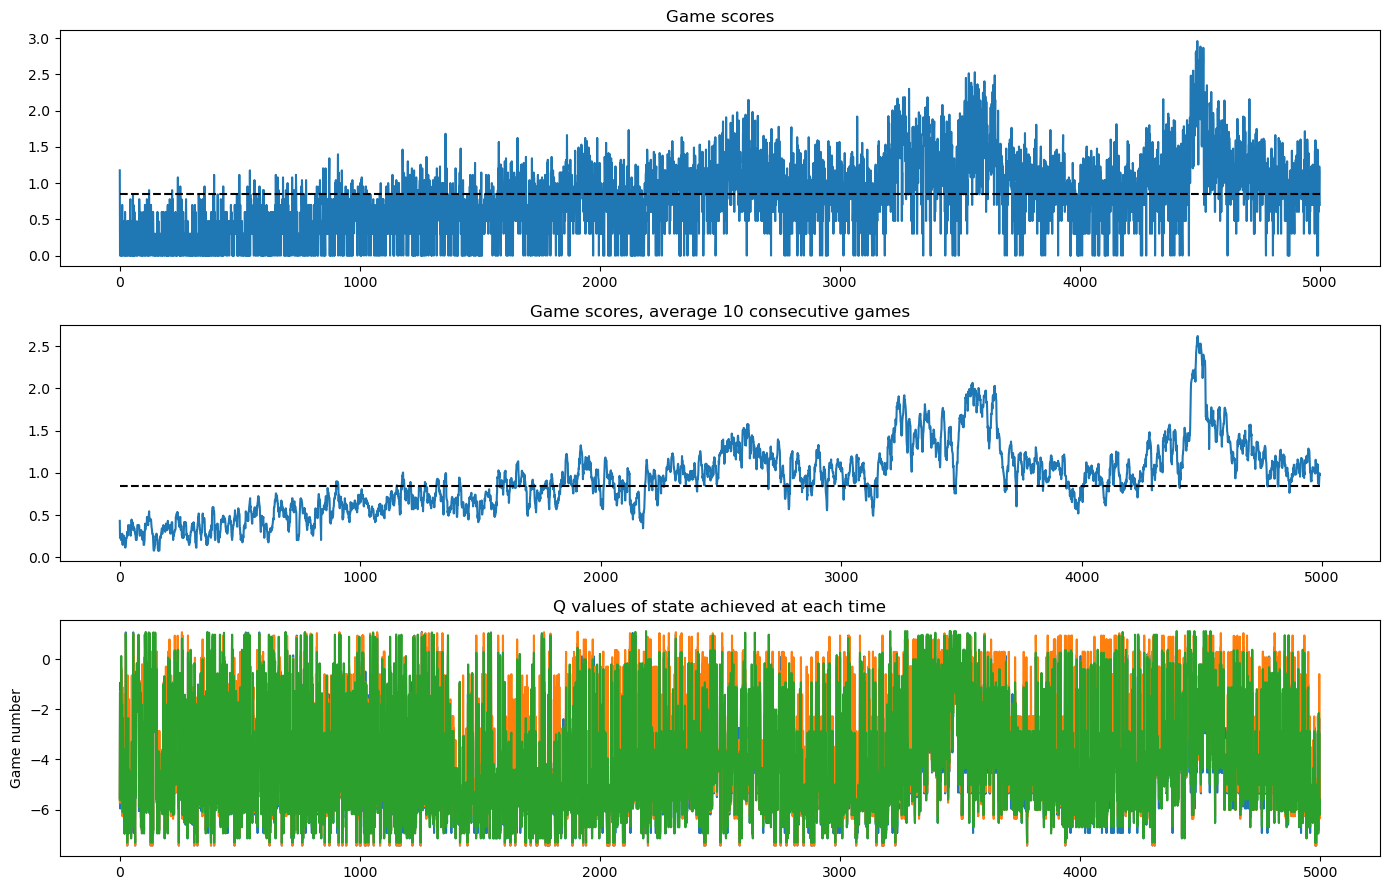

In [44]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,9),layout='tight')
ax = [ fig.add_subplot(3,1,x) for x in range(1,4) ]
ax[0].plot(np.arange(0,len(scores)),np.log10(1+np.array(scores)))
ax[0].plot([0,5000],np.log10([7,7]),'k--')
ax[0].set_title('Game scores')
ax[1].plot(np.arange(4991),np.log10(1+np.convolve(np.ones(10)/10,scores,mode='valid')))
ax[1].plot([0,4991],np.log10([7,7]),'k--')
ax[1].set_title('Game scores, average 10 consecutive games')
ax[2].plot(np.arange(0,len(q_achieved)),q_achieved)
ax[2].set_title('Q values of state achieved at each time')
ax[2].set_ylabel('Game number')

Hooray, it has learned!  If you are getting a ten-game average score of better than 6, then you are ready to submit your model for grading.   In order to do that, you need to save the model:

In [45]:
q_learner.save('trained_model.npz')

<a id='section9'></a>

## Extra Credit

For extra credit, download the file <a href="mp11_extra.zip">mp11_extra.zip</a>.  The only important file in this package is:
* `tests/test_extra.py`: this contains extra tests that will evaluate your pre-trained `deep_q` learner, which should be in a file called `trained_model.pkl`.  For full credit, your model should achieve an average score of greater than 20, averaged over 10 consecutive games. 

With a quantized lookup table, it's probably not possible to achieve an average score of 20.  With a deep-Q learner, however, it is eminently possible.  In order to do the extra credit, therefore, you should just fill in the part of `submitted.py` that implements the `deep_q` learner, using pytorch to define a model structure, train it, save it, load it, and act on it.  This learner only needs to have five methods: `__init__`, `act`, `learn`, `save`, and `load`:

In [47]:
importlib.reload(submitted)
help(submitted.deep_q.__init__)

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst)
    Create a new deep_q learner.
    Your q_learner object should store the provided values of alpha,
    epsilon, gamma, and nfirst.
    It should also create a deep learning model that will accept
    (state,action) as input, and estimate Q as the output.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of taking a random action
    gamma (scalar) - discount factor
    nfirst (scalar) - exploring each state/action pair nfirst times before exploiting
    
    @return:
    None



In [48]:
help(submitted.deep_q.act)

Help on function act in module submitted:

act(self, state)
    Decide what action to take in the current state.
    You are free to determine your own exploration/exploitation policy -- 
    you don't need to use the epsilon and nfirst provided to you.
    
    @params: 
    state: a list of 5 floats: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
    
    @return:
    -1 if the paddle should move upward
    0 if the paddle should be stationary
    1 if the paddle should move downward



In [49]:
help(submitted.deep_q.learn)

Help on function learn in module submitted:

learn(self, state, action, reward, newstate)
    Perform one iteration of training on a deep-Q model.
    
    @params:
    state: a list of 5 floats: ball_x, ball_y, ball_vx, ball_vy, paddle_y
    action: an integer, one of -1, 0, or +1
    reward: a reward; positive for hitting the ball, negative for losing a game
    newstate: a list of 5 floats, in the same format as state
    
    @return:
    None



In [50]:
help(submitted.deep_q.save)

Help on function save in module submitted:

save(self, filename)
    Save your trained deep-Q model to a file.
    This can save in any format you like, as long as your "load" 
    function uses the same file format.
    
    @params:
    filename (str) - filename to which it should be saved
    @return:
    None



In [51]:
help(submitted.deep_q.load)

Help on function load in module submitted:

load(self, filename)
    Load your deep-Q model from a file.
    This should load from whatever file format your save function
    used.
    
    @params:
    filename (str) - filename from which it should be loaded
    @return:
    None



<a id='grade'></a>

## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases (which you can read in `tests/test_visible.py`), and compare the results to the solutions (which you can read in `solution.json`).

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

In [54]:
!python grade.py

.....Completed 0 games, 30 rewards, 8125 frames, score 29, max score 29
Completed 1 games, 48 rewards, 10886 frames, score 17, max score 29
Completed 2 games, 64 rewards, 16802 frames, score 15, max score 29
Completed 3 games, 71 rewards, 21221 frames, score 6, max score 29
Completed 4 games, 86 rewards, 25431 frames, score 14, max score 29
Completed 5 games, 89 rewards, 26294 frames, score 2, max score 29
Completed 6 games, 99 rewards, 29810 frames, score 9, max score 29
Completed 7 games, 119 rewards, 33539 frames, score 19, max score 29
Completed 8 games, 131 rewards, 37423 frames, score 11, max score 29
Completed 9 games, 133 rewards, 38157 frames, score 1, max score 29
.
----------------------------------------------------------------------
Ran 6 tests in 1.187s

OK


Now you should try uploading your code to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.  

**Warning:** For this MP you need to update two files, not just one. 
* `trained_model.npz` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.

**Warning:** The autograder calculates the average score over ten random games.  If you are getting an average score above 10 almost all the time on your own computer, and if the autograder says you had a score below 10, try resubmitting to see if the next round of random games is better.

**Extra Credit:** Your extra credit should also be uploaded as two files,
* `trained_model.pkl` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.